<a href="https://colab.research.google.com/github/ishwars1618/clustering_autoencoders/blob/main/clust_autoenc_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# Typical libraries for data science
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # graphing
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

# Pytorch
import torch
import torchvision
# transform is used to convert data into Tensor form with transformations
import torchvision.transforms as transforms
# libraries to generate Random Subset & dataLoader to feed Batch of data to model, as feeding whole dataset may lead to System failure or Hang
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

import cv2

# Keras library used for neural networks
#!pip install tensorflow==2.2.0-rc3
#!pip install keras==2.14


import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Conv2D, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential


# sklearn used for K-means clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

TensorFlow version: 2.14.0


In [2]:
trans = transforms.Compose([
    # To resize image
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    # To normalize image
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.MNIST(
root = './data',
train = True,
download = True,
transform = trans
)


train_set_np = train_set.data.numpy()
train_set_label_np = train_set.targets.numpy()
train_set_np_32 = np.zeros(shape=(train_set_np.shape[0],32, 32))
for i in range(0, train_set_np.shape[0]):
  train_set_np_32[i] = cv2.resize(train_set_np[i], (32, 32), interpolation=cv2.INTER_CUBIC)

"""
n_per_number = 50
# select first n_per_number for each number
train_set_np_32_small = np.zeros(shape=(n_per_number*10,32, 32))
train_set_label_small = np.zeros(shape=(n_per_number*10,), dtype=int)
count_arr = [0 for i in range(0,10)]
i = 0
small_i = 0
while small_i < n_per_number*10:
  number = train_set_label_np[i]
  if (count_arr[number] == n_per_number):
    pass
  elif (count_arr[number] <= n_per_number):
    train_set_np_32_small[small_i] = train_set_np_32[i]
    train_set_label_small[small_i] = train_set_label_np[i]
    small_i += 1
    count_arr[number] += 1
  else:
    print("Count_arr["+str(number)+"] exceeded n_per_number??")
  #print(count_arr)
  i += 1
"""

train_set_np_32_small = train_set_np_32
train_set_label_small = train_set_label_np

print(train_set_np.shape)
print(train_set_np_32.shape)
print(train_set_label_np.shape)
print(train_set_np_32_small.shape)
print(train_set_label_small.shape)

100%|██████████| 9912422/9912422 [00:00<00:00, 243727166.51it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 105335385.93it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 126599754.64it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19761959.30it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

(60000, 28, 28)
(60000, 32, 32)
(60000,)
(60000, 32, 32)
(60000,)


2


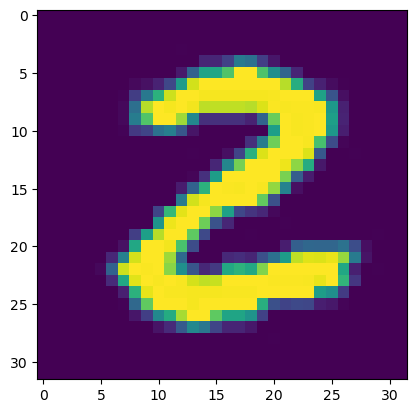

In [ ]:
n=25
print(train_set_label_small[n])
plt.imshow(train_set_np_32_small[n])

In [75]:
from keras.src.layers.rnn.lstm import RECURRENT_DROPOUT_WARNING_MSG
# create distribution from clustering

def cluster(num_clus, data_set):
    clustering = [[] for i in range(0, num_clus)]
    km = KMeans(n_clusters=num_clus,random_state=42).fit(data_set)
    labels = km.labels_
    print(labels)
    for c in range(0, num_clus):
        for l in range(0, len(labels)):
            if (labels[l] == c):
                clustering[c].append(l)
    return clustering

def create_dist(clustering, img_labels, k):
  cluster_arr_k = clustering[k]
  dist = [0 for i in range(0, 10)]
  for i in cluster_arr_k:
    #print(i)
    dist[img_labels[i]] += 1
  dist_sum = 0
  for j in range(0, 10):
    dist_sum += dist[j]
  #print(dist_sum)
  #for j in range(0, 10):
  #  dist[j] /= dist_sum
  return dist

def print_dist(dist):
  print("Number:\t\t", end="")
  for i in range(0, 10):
    print(str(i)+",\t", end="")
  print()
  print("Frequency:\t", end="")
  for i in range(0, 10):
    print(str(dist[i])+",\t", end="")
  print()

def evaluate_clustering(clustering):
  global train_set_label_small

  dist_arr = [[] for i in range(0,len(clustering))]
  i = 0
  while i < len(clustering):
    if len(clustering[i]) == 0:
        del clustering[i]
        i -= 1
    else:
        dist_arr[i] = create_dist(clustering, train_set_label_small, i)
    i += 1

  print("Number:\t\t", end="")
  for i in range(0, 10):
    print(str(i)+",\t", end="")
  print()
  for i in range(0, len(clustering)):
    print("Cluster "+str(i)+":\t", end="")
    for j in range(0, 10):
      print(str(dist_arr[i][j])+",\t", end="")
    print()

  peak_dist_arr = [0 for i in range(0,len(clustering))]
  peak_dist_arr_nums = [[] for i in range(0,len(clustering))]
  for i in range(0, len(clustering)):
    # get peak frequency and number corr. to peak in distribution
    max_ind = -1
    max_freq = -1
    for j in range(0, 10):
      if (max_freq < dist_arr[i][j]):
        max_freq = dist_arr[i][j]
        max_ind = j
    peak_dist_arr[i] = max_freq / len(clustering[i])

    max_inds = []
    for j in range(0, 10):
      if (max_freq == dist_arr[i][j]):
        max_inds.append(j)
    peak_dist_arr_nums[i] = max_inds

  print()
  print("Accuracy of each cluster:")
  for i in range(0, len(clustering)):
    print("Cluster "+str(i)+":\t", end="")
    print(str(round(peak_dist_arr[i],3))+";\t"+str(peak_dist_arr_nums[i]))

def pca_dataset(dataset):
  length = dataset.shape[0]
  dimension = 1
  for i in range(1, len(dataset.shape)):
    dimension *= dataset.shape[i]
  dataset_flattened = dataset.reshape((length, dimension))
  #print(dataset_flattened.shape)
  pca = PCA(n_components=2)
  return pca.fit_transform(dataset_flattened)
"""
def prepare_plot(ax, dataset_2x1, dataset):
  for i in range(0, len(dataset)):
    ab = AnnotationBbox(OffsetImage(dataset[i], zoom=5, cmap='gray'), (dataset_2x1[0], dataset_2x1[1]), frameon=False)
    ax.add_artist(ab)

fig, ax = plt.subplots()
prepare_plot(ax, train_set_np_32_small_pca, train_set_np_32_small)
plt.show()
"""

"\ndef prepare_plot(ax, dataset_2x1, dataset):\n  for i in range(0, len(dataset)):\n    ab = AnnotationBbox(OffsetImage(dataset[i], zoom=5, cmap='gray'), (dataset_2x1[0], dataset_2x1[1]), frameon=False)\n    ax.add_artist(ab)\n\nfig, ax = plt.subplots()\nprepare_plot(ax, train_set_np_32_small_pca, train_set_np_32_small)\nplt.show()\n"

In [76]:
# check distribution of original
cl_degenerate = [[i for i in range(0,len(train_set_label_small))]]
dist_degenerate = create_dist(cl_degenerate, train_set_label_small, 0)
dist_degenerate

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]

In [4]:
"""
print(train_set_np_32_small[0].shape)
flattened_train_np = train_set_np_32_small.reshape((len(train_set_np_32_small), train_set_np_32_small[0].shape[0] * train_set_np_32_small[0].shape[1]))
print(flattened_train_np.shape)
cl = cluster(10, flattened_train_np)
for i in range(0, len(cl)):
  print("Cluster "+str(i)+": "+str(cl[i]))
"""

(32, 32)
(60000, 1024)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[6 5 3 ... 6 1 6]
[4, 9, 15, 19, 22, 28, 33, 42, 43, 45, 54, 57, 71, 79, 84, 87, 89, 91, 96, 101, 103, 115, 123, 127, 131, 133, 139, 141, 142, 148, 153, 163, 166, 167, 168, 183, 185, 193, 195, 223, 227, 230, 243, 247, 257, 258, 263, 267, 268, 271, 280, 285, 288, 289, 297, 301, 305, 307, 313, 319, 324, 329, 336, 337, 349, 353, 362, 363, 364, 369, 371, 373, 377, 379, 383, 387, 389, 409, 411, 413, 419, 422, 423, 441, 461, 467, 471, 478, 481, 482, 483, 487, 505, 518, 521, 522, 525, 529, 531, 541, 567, 569, 585, 586, 589, 590, 595, 599, 601, 614, 617, 621, 624, 626, 636, 647, 651, 654, 655, 663, 664, 680, 683, 687, 697, 700, 703, 707, 717, 723, 727, 728, 730, 741, 749, 753, 754, 755, 772, 773, 793, 795, 797, 803, 819, 827, 839, 847, 853, 854, 855, 868, 880, 883, 887, 888, 894, 896, 898, 911, 928, 929, 930, 933, 934, 937, 942, 945, 948, 950, 954, 962, 967, 969, 971, 980, 981, 987, 995, 1001, 1005, 1019, 1022, 1036, 1037, 1043, 1054, 1057, 1061, 1066, 1072, 1073, 1082, 1099, 1103, 1114, 1122,

In [77]:
print(train_set_np_32_small[0].shape)
flattened_pca = pca_dataset(train_set_np_32_small)
print(flattened_pca.shape)
cl = cluster(10, flattened_pca)
for i in range(0, len(cl)):
  print("Cluster "+str(i)+": "+str(cl[i]))
print()
evaluate_clustering(cl)

(32, 32)
(60000, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[6 2 9 ... 1 1 1]
Cluster 0: [4, 9, 26, 38, 42, 57, 71, 79, 96, 100, 109, 127, 133, 134, 139, 148, 150, 153, 163, 166, 176, 195, 204, 212, 226, 227, 228, 230, 247, 258, 264, 267, 268, 271, 280, 282, 285, 288, 289, 292, 304, 305, 307, 313, 319, 336, 342, 353, 354, 363, 364, 372, 373, 379, 384, 389, 409, 411, 412, 419, 422, 423, 428, 434, 436, 441, 459, 468, 471, 476, 478, 482, 487, 500, 509, 518, 525, 536, 547, 566, 567, 576, 584, 589, 590, 592, 599, 614, 617, 621, 624, 627, 636, 647, 651, 654, 664, 682, 686, 706, 707, 744, 754, 762, 770, 778, 786, 795, 803, 824, 827, 839, 853, 868, 880, 888, 894, 898, 906, 933, 945, 950, 968, 971, 980, 1007, 1022, 1036, 1037, 1042, 1056, 1057, 1061, 1073, 1082, 1094, 1098, 1110, 1125, 1133, 1138, 1149, 1153, 1156, 1157, 1163, 1164, 1166, 1169, 1171, 1173, 1190, 1198, 1205, 1229, 1232, 1250, 1256, 1260, 1280, 1281, 1286, 1288, 1292, 1300, 1302, 1307, 1316, 1326, 1328, 1335, 1338, 1342, 1347, 1355, 1396, 1400, 1402, 1410, 1416, 1422, 1426, 1430, 1459, 14

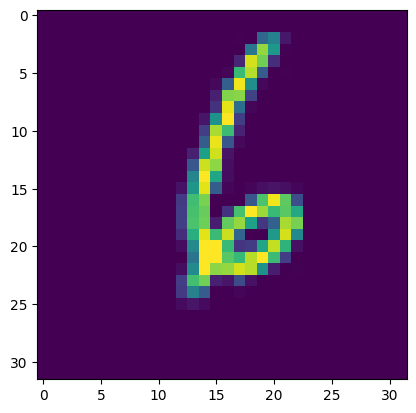

In [54]:
cluster_id = 2
k = 50
img_index = cl[cluster_id][k]
plt.imshow(train_set_np_32_small[img_index])

In [55]:
from keras.src.layers.rnn.base_rnn import layer_serialization
# autoencoder

def create_cnn():
  global train_set_np
  input_shape = (train_set_np_32[0].shape[0], train_set_np_32[0].shape[1], 1)

  autoencoder = Sequential()
  # create input layer
  autoencoder.add(Input(shape = input_shape))
  # create encoder part
  for i in range(0,3):
    autoencoder.add(Conv2D(4, (3, 3), activation="relu", padding="same"))
    autoencoder.add(Conv2D(4, (3, 3), activation="relu", padding="same"))
    autoencoder.add(MaxPooling2D((2, 2), padding="same"))
  autoencoder.add(Conv2D(1,(3, 3), activation="relu", padding="same"))

  for i in range(0,3):
    autoencoder.add(UpSampling2D((2, 2)))
    autoencoder.add(Conv2D(4, (3, 3), activation="relu", padding="same"))
    autoencoder.add(Conv2D(4, (3, 3), activation="relu", padding="same"))
  autoencoder.add(Conv2D(1,(3, 3), activation="relu", padding="same"))

  autoencoder.compile(optimizer = "adam", loss = "mean_squared_error")

  encoder = Sequential()
  encoder.add(Input(shape = input_shape))
  for i in range(0, (len(autoencoder.layers)-1)//2 + 1):
    encoder.add(autoencoder.layers[i])

  decoder = Sequential()
  decoder.add(Input(shape = input_shape))
  for i in range((len(autoencoder.layers)-1)//2 + 1, len(autoencoder.layers)):
    decoder.add(autoencoder.layers[i])

  latent_shape = encoder.layers[-1].output_shape[1:]

  return autoencoder, encoder, decoder, latent_shape

In [ ]:
ae,e,d,ls= create_cnn()
print(ae.summary())
print(ls)
print(d.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 4)         40        
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 4)         148       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 4)         148       
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 4)         148       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 4)           0         
 g2D)                                                 

In [ ]:
ae.fit(train_set_np_32_small, train_set_np_32_small, batch_size=16, epochs=100)

Epoch 1/100
3750/3750 [==============================] - 34s 9ms/step - loss: 1970.0366
Epoch 2/100
3750/3750 [==============================] - 33s 9ms/step - loss: 1334.6879
Epoch 6/100
3750/3750 [==============================] - 33s 9ms/step - loss: 1309.1899
Epoch 7/100
3750/3750 [==============================] - 34s 9ms/step - loss: 1290.9194
Epoch 8/100
3750/3750 [==============================] - 33s 9ms/step - loss: 1272.0762
Epoch 9/100
3750/3750 [==============================] - 33s 9ms/step - loss: 1257.8523
Epoch 10/100
3750/3750 [==============================] - 33s 9ms/step - loss: 1243.8256
Epoch 11/100
3750/3750 [==============================] - 33s 9ms/step - loss: 1233.3436
Epoch 12/100
3750/3750 [==============================] - 33s 9ms/step - loss: 1221.4960
Epoch 13/100
3750/3750 [==============================] - 33s 9ms/step - loss: 1214.4017
Epoch 14/100
3750/3750 [==============================] - 33s 9ms/step - loss: 1206.8075
Epoch 15/100
3750/3750 [===

3750/3750 [==============================] - 34s 9ms/step - loss: 1065.3341
Epoch 97/100
3750/3750 [==============================] - 33s 9ms/step - loss: 1065.5635
Epoch 98/100
3750/3750 [==============================] - 33s 9ms/step - loss: 1063.9503
Epoch 99/100
3750/3750 [==============================] - 33s 9ms/step - loss: 1063.7249
Epoch 100/100
3750/3750 [==============================] - 33s 9ms/step - loss: 1063.0297


In [ ]:
ae.save('autoenc-2.h5')
e.save('enc-2.h5')
d.save('dec-2.h5')

In [78]:
# test load
ae = tf.keras.models.load_model('autoenc.h5')
e = tf.keras.models.load_model('enc.h5')
d = tf.keras.models.load_model('dec.h5')
ae.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 4)         40        
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 4)         148       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 4)         148       
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 4)         148       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 4)           0         
 g2D)                                                 

In [79]:
ae_enc_dec = ae.predict(train_set_np_32_small)
ae_enc = e.predict(train_set_np_32_small)

1875/1875 [==============================] - 4s 2ms/step


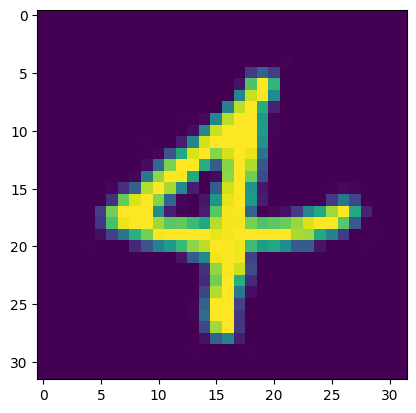

In [84]:
img_index = 150
plt.imshow(train_set_np_32_small[img_index])

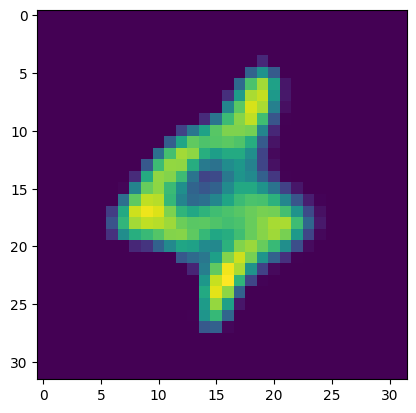

In [85]:
plt.imshow(ae_enc_dec[img_index])

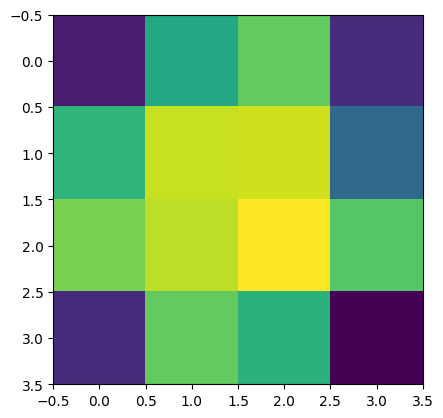

In [86]:
plt.imshow(ae_enc[img_index])

In [90]:
print(ae_enc[0].shape)
flattened_enc_pca = pca_dataset(ae_enc)
print(flattened_enc_pca.shape)
cl_enc = cluster(9, flattened_enc_pca)
for i in range(0, len(cl_enc)):
  print("Cluster "+str(i)+": "+str(cl_enc[i]))
print()
evaluate_clustering(cl_enc)

(4, 4, 1)
(60000, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[4 7 4 ... 1 6 6]
Cluster 0: [12, 20, 28, 36, 58, 68, 108, 120, 164, 182, 190, 194, 198, 216, 222, 241, 246, 284, 298, 306, 323, 330, 378, 380, 386, 390, 392, 400, 404, 424, 452, 486, 488, 490, 494, 504, 516, 528, 582, 606, 616, 658, 668, 722, 732, 734, 752, 764, 792, 804, 810, 826, 828, 830, 840, 848, 862, 874, 882, 886, 890, 910, 916, 924, 970, 974, 984, 986, 990, 992, 1048, 1050, 1076, 1108, 1116, 1130, 1134, 1158, 1160, 1162, 1194, 1196, 1206, 1213, 1226, 1249, 1255, 1257, 1264, 1276, 1290, 1314, 1352, 1361, 1366, 1370, 1380, 1382, 1385, 1399, 1400, 1401, 1424, 1432, 1440, 1448, 1454, 1460, 1488, 1494, 1504, 1508, 1526, 1534, 1546, 1556, 1560, 1581, 1583, 1586, 1602, 1604, 1616, 1620, 1622, 1629, 1631, 1646, 1649, 1672, 1684, 1692, 1698, 1711, 1756, 1764, 1768, 1774, 1778, 1794, 1809, 1820, 1826, 1840, 1841, 1849, 1861, 1869, 1892, 1912, 1918, 1932, 1940, 1947, 1948, 1964, 1966, 1974, 1980, 1984, 1994, 2002, 2007, 2017, 2019, 2027, 2029, 2034, 2035, 2068, 2073, 2075, 2093, 2107, 21